# APS360 - Classifying Subreddits

Bassam Bibi<br>
Matthew Kwan

## Imports

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('./data/updated_datav2.csv')
df.head()

,Unnamed: 0,id,post,score,subreddit,title,url
0,0,0,NaN,53782,0,"New ""Discovery Mode"" turns video game ""Assassi...",https://www.theverge.com/2018/2/20/17033024/as...
1,1,1,"Hi everyone and especially our students,\r\n\r...",38426,0,We are not here to help you with your End of T...,https://www.reddit.com/r/history/comments/8pw3...
2,2,2,NaN,35982,0,A 1776 excerpt from John Adam's diary where he...,https://founders.archives.gov/documents/Adams/...
3,3,3,NaN,34908,0,Famous Viking warrior burial revealed to be th...,http://www.news.com.au/technology/science/arch...
4,4,4,NaN,34197,0,"3,000-year-old underwater castle discovered in...",https://inhabitat.com/3000-year-old-underwater...


### Splitting Function for Punctuations

In [3]:
def split_post(post):
    # separate punctuations
    post = post.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") 

    return post.split() # Returns each word as an index in a list


### Download GloVe Vectors

In [4]:
# Download pre-trained glove vectors

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) 

.vector_cache\glove.6B.zip: 862MB [07:14, 1.99MB/s]                                                                    
  2%|█▊                                                                       | 9836/400000 [00:00<00:28, 13575.90it/s]


### Function the Split Data into Train, Test and Valid

In [5]:
def get_post_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(df.post):
        if i%3 == 0:
            
            # If there is no text content in the post, then use the title of the post instead
            
            if line is np.nan:
                post = df.title[i]
            else:
                post = line
            
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_post(post)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore posts without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(df.subreddit[i]).long() #IMPORTANT, need to convert this to numerical category
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train,valid,test = get_post_words(glove)

In [6]:
print("Train Length: {} Val Length: {} Test Length: {}".format(len(train),len(valid),len(test)))

Train Length: 2497 Val Length: 836 Test Length: 833


## Batching

In [7]:
import random

class PostBatcher:
    def __init__(self, posts, batch_size=32, drop_last=False):
        # store posts by length
        self.posts_by_length = {}
        for words, label in posts:
            # compute the length of the post
            wlen = words.shape[0]
            # put the posts in the correct key inside self.posts_by_length
            if wlen not in self.posts_by_length:
                self.posts_by_length[wlen] = []
            self.posts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of posts of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    posts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, posts in self.posts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every post length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

With our batching function working, let's define our data loaders. Let's start with a batch-size of 16:

In [58]:
train_loader = PostBatcher(train,batch_size=16,drop_last=True)
valid_loader = PostBatcher(train,batch_size=16,drop_last=True)

In [59]:
for i, (posts, labels) in enumerate(train_loader):
    if i > 5: break
    print(posts.shape, labels.shape)

torch.Size([16, 9]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 6]) torch.Size([16])
torch.Size([16, 12]) torch.Size([16])
torch.Size([16, 24]) torch.Size([16])


In [44]:
train_loader

## Preliminary Model

In [8]:
class RedditLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=13):
        super(RedditLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(3, x.size(0), self.hidden_size)
        c0 = torch.zeros(3, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Training 

In [9]:
# Function to calculate the accuracy of the results. 
# Returns: # of Correct Predictions / Total # of Predictions

def get_accuracy(model, data_loader, find_loss=False):
  
    criterion = nn.CrossEntropyLoss()

    correct, total = 0, 0
    for posts, labels in data_loader:
        output = model(posts)
        if find_loss == True:
            loss = criterion(output,labels)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
   
    if find_loss == False:
        return correct / total
    else:
        return correct / total,loss

In [13]:
def train_rnn_network(model, train, valid, num_epochs=200, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%50 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

Epoch 0; Train Loss 2.557267; Validation Loss 2.540540; Train Acc 0.182181; Val Acc 0.179521
Epoch 50; Train Loss 1.432354; Validation Loss 1.851048; Train Acc 0.404255; Val Acc 0.424202
Epoch 100; Train Loss 0.906770; Validation Loss 1.421307; Train Acc 0.501330; Val Acc 0.511968
Epoch 150; Train Loss 0.914209; Validation Loss 0.860502; Train Acc 0.555851; Val Acc 0.579787


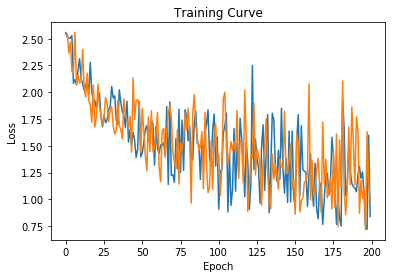

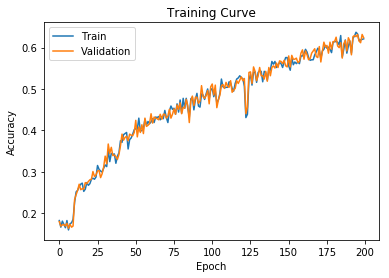

In [34]:
model = RedditLSTM(50,50)
train_rnn_network(model,train_loader,valid_loader)

In [55]:
# Create Test Loader
test_loader = PostBatcher(test,batch_size=16,drop_last=True)

In [56]:
test_acc = get_accuracy(model,test_loader)
print("Our accuracy on our test set was: {}".format(test_acc))

Our accuracy on our test set was: 0.546875


## Tuning Hyperparameters
First, let's try increasing the batch size to 32:

Epoch 0; Train Loss 2.575501; Validation Loss 2.569559; Train Acc 0.156250; Val Acc 0.160417
Epoch 50; Train Loss 1.890330; Validation Loss 1.718818; Train Acc 0.325000; Val Acc 0.347917


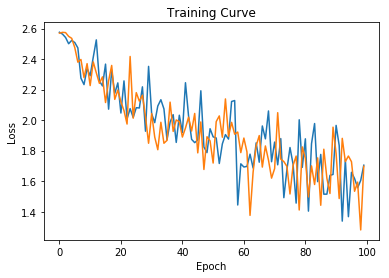

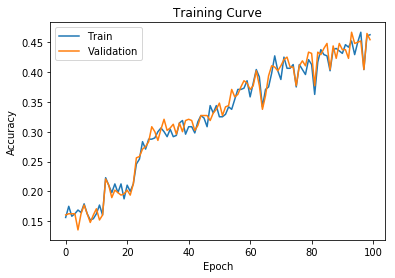

In [60]:
train_loader = PostBatcher(train,batch_size=32,drop_last=True)
valid_loader = PostBatcher(train,batch_size=32,drop_last=True)
model = RedditLSTM(50,50)
train_rnn_network(model,train_loader,valid_loader,num_epochs=100)

## Random Search
A function to help with hyperparameter tuning.

In [12]:
def RandomSearch(n_iters, batch_sizes, learning_rates, hidden_sizes):
    """
    n_iters: number of iterations to perform.
    batch_sizes: list of batch sizes.
    learning_rates: list of learning rates.
    hidden_sizes: list of hidden unit sizes.
    """
    list_data = []
    
    for i in range(n_iters):
        bs = np.random.randint(0,high=len(batch_sizes))
        lr = np.random.randint(0,high=len(learning_rates))
        hs = np.random.randint(0,high=len(hidden_sizes))
        
        train_loader = PostBatcher(train,batch_size=batch_size[bs],drop_last=True)
        valid_loader = PostBatcher(valid,batch_size=batch_size[bs],drop_last=True)
        
        model = RedditLSTM(50)
        
        result = train_rnn_network(model,train_loader,valid_loader,num_epochs=100)
        
        list_data.append([i,batch_size[bs],learning_rates[lr],hidden_sizes[hs],result[0],result[1],result[2],result[3]])
        
    df = pd.Dataframe(list_data,columns=["Iter", "batch size", "learning rate", "hidden size", "train loss",
                                         "valid loss","train acc", "valid acc"])
    
    df.to_csv('Random Search.csv',index = False)